<a href="https://colab.research.google.com/github/rishuatgithub/MLPy/blob/master/Topic_Modelling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling using Latent-Dirichlet Allocation

- Blog URL : [Topic Modelling : Latent Dirichlet Allocation, an introduction](https://anotherreeshu.wordpress.com)
- Author   : Rishu Shrivastava

In [1]:
## Installing pyldaviz for visualization.
!pip install pyldavis

     |████████████████████████████████| 1.6MB 3.8MB/s 
     |████████████████████████████████| 552kB 32.1MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=d35dd8d12444093adb88ad068bfd400f78edada2c2cd3f876979c061b2e505ce
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=be6e16f43d9f916856d3636a79373f9e2deecaf3c1a51cbe438e45e4f4e60c96
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyLDAvis
from pyLDAvis import sklearn as skl
pyLDAvis.enable_notebook()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Step 1: Loading and Understanding Data

As part of this step we will load the data into the dataframe

- Dataset Kernel : https://www.kaggle.com/hengzheng/news-category-classifier-val-acc-0-65

In [4]:
### Reading the dataset from path

filename = '/content/drive/My Drive/Colab Notebooks/data/news_data/News_Category_Dataset_v2.json'
data = pd.read_json(filename, lines=True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
### Total volume of data

data.shape

(200853, 6)

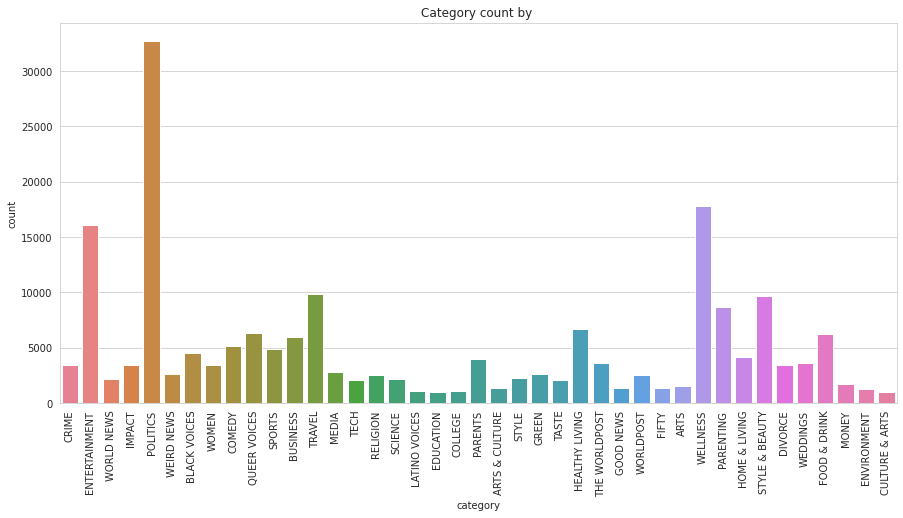

In [10]:
### Total volume by categories

plt.figure(figsize=(15,7))
sns.set_style("whitegrid")
sns.countplot(x='category',data=data, orient='h', palette='husl')
plt.xticks(rotation=90)
plt.title("Category count of article")
plt.show()

For the purpose of this demo and blog, we will do the following:
  1.   **Reduce** the total number of **categories** from the dataset to make it simple.
  2.   **Combine** both the **Headline and Short Description** into one single column to bring more context to the news and corpus. Calling it as: ```Combined_Description```
  3.  **Drop** rest of the attributes from the dataframe other than Combined_Description and Categories.



In [27]:
### Filter the dataset to reduce the dataset (just for the purpose of this work)

data['Combined_Description'] = data['headline'] + data['short_description']
filtered_data = data[(data['category']=='ENTERTAINMENT') | (data['category']=='TRAVEL') | (data['category']=='RELIGION') | (data['category']=='FOOD & DRINK') | (data['category']=='HEALTHY LIVING')]
filtered_data = filtered_data[['category','Combined_Description']]

filtered_data.head()

,category,Combined_Description
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...


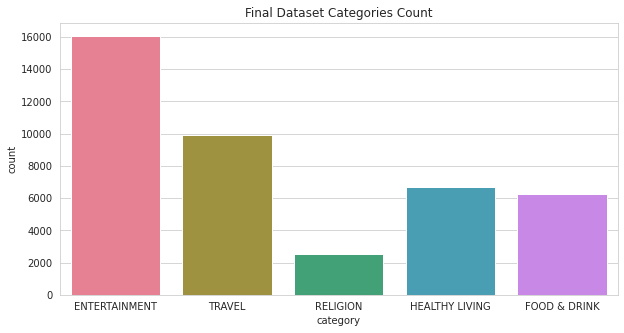

In [28]:
### Lets check the filtered dataset available. We will use this category to validate our LDA topic result.
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
sns.countplot(x='category', data=filtered_data, palette='husl')
plt.title("Final Dataset Categories Count")
plt.show()

In [29]:
filtered_data.shape

(41421, 2)

### Step 2: Pre-processing data

**a. Applying Count Vectorizer to pre-process the data into vectors.**

In the parameters section of CountVectorizer(), we define the max_df and min_df.

- max_df : Ignore the words that occurs more than 95% of the corpus. 
- min_df : Accept the words in preparation of vocab that occurs in atleast 2 of the documents in the corpus.
- stop_words : Remove the stop words. We can do this in separate steps or in a single step.

In [0]:
#df_cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
df_cv = TfidfVectorizer(stop_words='english')

In [0]:
df_cv_transformed = df_cv.fit_transform(filtered_data['Combined_Description'])

In [32]:
df_cv_transformed

<41421x65282 sparse matrix of type '<class 'numpy.float64'>'
	with 577705 stored elements in Compressed Sparse Row format>

*Here you can notice that the transformed dataset holds a sparse matrix with a dimension of 58109x28637; where 58109 is the total number of rows and 28637 is the total word corpus.*

### Step 3: Building Latent-Dirichlet Algorithm using scikit-learn

In [0]:
### Define the LDA model and set the topic size to 5.

lda_model = LatentDirichletAllocation(n_components=5, batch_size=128, random_state=42)

In [34]:
### Fit the filtered data to the model

lda_model.fit(df_cv_transformed)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

### Step 4: Display the Topics

In [38]:
topic_word_dict = {}

top_n_words_num = 10

for index, topic in enumerate(lda_model.components_):
  topic_id = index+1
  topic_words_max = [df_cv.get_feature_names()[i] for i in topic.argsort()[:(-1 * top_n_words_num)-1:-1]]
  topic_word_dict[topic_id] = topic_words_max
  print(f"Topic ID : {topic_id}; Top 10 Most Words : {topic_words_max}")

Topic ID : 1; Top 10 Most Words : ['photos', 'best', 'food', 'new', 'recipes', 'make', 'like', 'world', 'day', 'just']
Topic ID : 2; Top 10 Most Words : ['daily', 'life', 'new', 'meditation', 'people', 'need', 'time', 'help', 'know', 'make']
Topic ID : 3; Top 10 Most Words : ['new', 'travel', 'time', 'world', 'people', 'best', 'photos', 'year', 'day', 'just']
Topic ID : 4; Top 10 Most Words : ['new', 'like', 'just', 'know', 'life', 'people', 'best', 'health', 'make', 'time']
Topic ID : 5; Top 10 Most Words : ['new', 'star', 'trump', 'says', 'donald', 'year', 'music', 'just', 'love', 'kardashian']


### Step 5: Attaching Topics to the Dataframe

In [0]:
topic_output = lda_model.transform(df_cv_transformed)

In [40]:
topic_word_dict[1]

['photos',
 'best',
 'food',
 'new',
 'recipes',
 'make',
 'like',
 'world',
 'day',
 'just']

In [0]:
filtered_data['LDA_Topic_ID'] = topic_output.argmax(axis=1)+1

filtered_data['Topic_word_categories'] = filtered_data['LDA_Topic_ID'].apply(lambda id: topic_word_dict[id])

In [42]:
filtered_data[['category','Combined_Description','LDA_Topic_ID','Topic_word_categories']].head()

,category,Combined_Description,LDA_Topic_ID,Topic_word_categories
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,1,"[photos, best, food, new, recipes, make, like,..."
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,2,"[daily, life, new, meditation, people, need, t..."
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,1,"[photos, best, food, new, recipes, make, like,..."
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,5,"[new, star, trump, says, donald, year, music, ..."
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,5,"[new, star, trump, says, donald, year, music, ..."


### Step 6: Visualizing

In [0]:
viz = skl.prepare(lda_model,df_cv_transformed,df_cv)

In [44]:
pyLDAvis.display(viz)